In [ ]:
import kagglehub


path = kagglehub.dataset_download("shahir/protein-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'protein-data-set' dataset.
Path to dataset files: /kaggle/input/protein-data-set


In [ ]:
import pandas as pd
df=pd.read_csv("/kaggle/input/protein-data-set/pdb_data_no_dups.csv")

seq_df = pd.read_csv('/kaggle/input/protein-data-set/pdb_data_seq.csv')


seq_df = seq_df[['structureId', 'sequence']].drop_duplicates()


df = df.merge(seq_df, on='structureId', how='inner')




In [ ]:
top_classes = df['classification'].value_counts().head(20).index
df = df[df['classification'].isin(top_classes)]
df["classification"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               167384 non-null  object 
 1   classification            167384 non-null  object 
 2   experimentalTechnique     167384 non-null  object 
 3   macromoleculeType         144078 non-null  object 
 4   residueCount              167384 non-null  int64  
 5   resolution                161750 non-null  float64
 6   structureMolecularWeight  167384 non-null  float64
 7   crystallizationMethod     106132 non-null  object 
 8   crystallizationTempK      106789 non-null  float64
 9   densityMatthews           129195 non-null  float64
 10  densityPercentSol         129135 non-null  float64
 11  pdbxDetails               132478 non-null  object 
 12  phValue                   118130 non-null  float64
 13  publicationYear           149216 non-null  float6

In [ ]:

missing_summary = pd.DataFrame({
    'missing_count': df.isnull().sum(),
    'missing_percent': df.isnull().sum() / len(df) * 100
})
missing_summary = missing_summary.sort_values('missing_count', ascending=False)
print(missing_summary)

                          missing_count  missing_percent
crystallizationMethod             61252        36.593701
crystallizationTempK              60595        36.201190
phValue                           49254        29.425752
densityPercentSol                 38249        22.851049
densityMatthews                   38189        22.815203
pdbxDetails                       34906        20.853845
macromoleculeType                 23306        13.923673
publicationYear                   18168        10.854084
resolution                         5634         3.365913
sequence                              2         0.001195
structureMolecularWeight              0         0.000000
structureId                           0         0.000000
residueCount                          0         0.000000
classification                        0         0.000000
experimentalTechnique                 0         0.000000


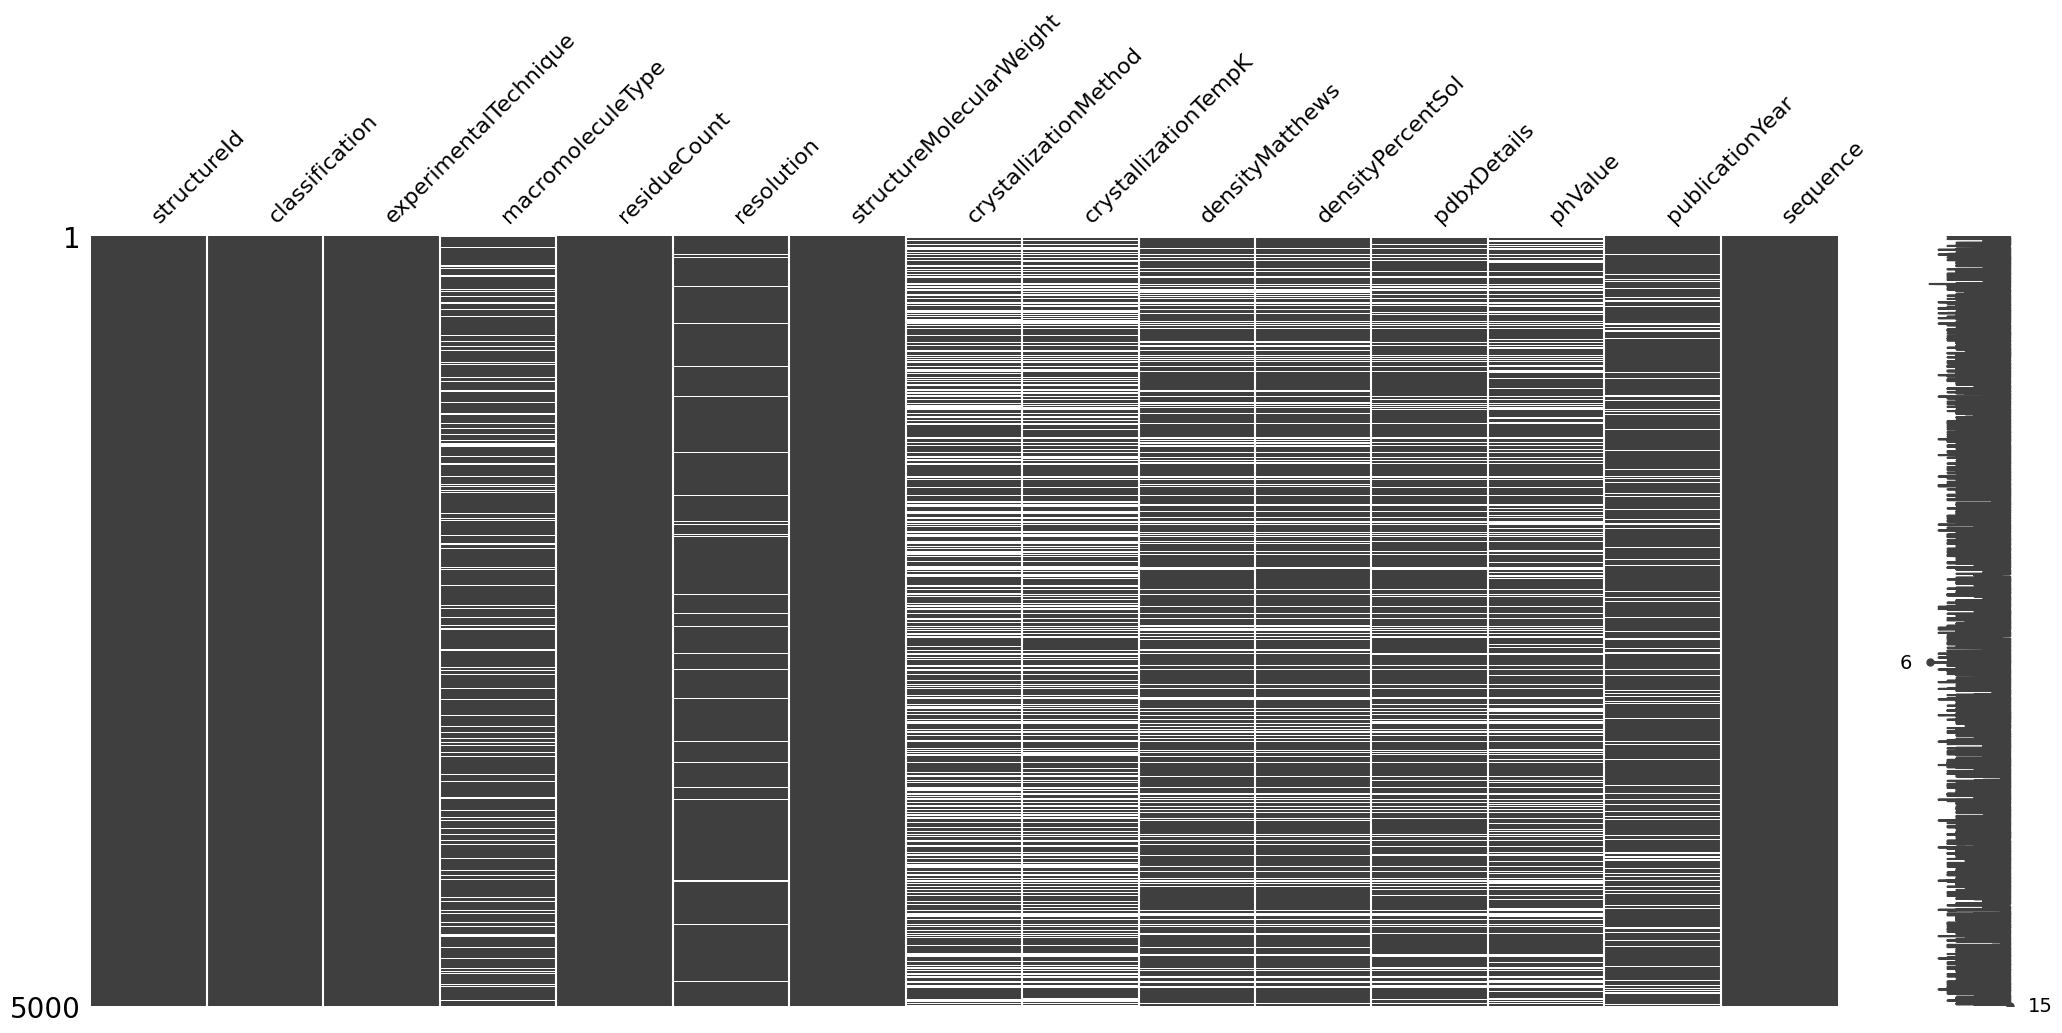

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df.sample(5000))  # Sample for speed
plt.show()

<Axes: >

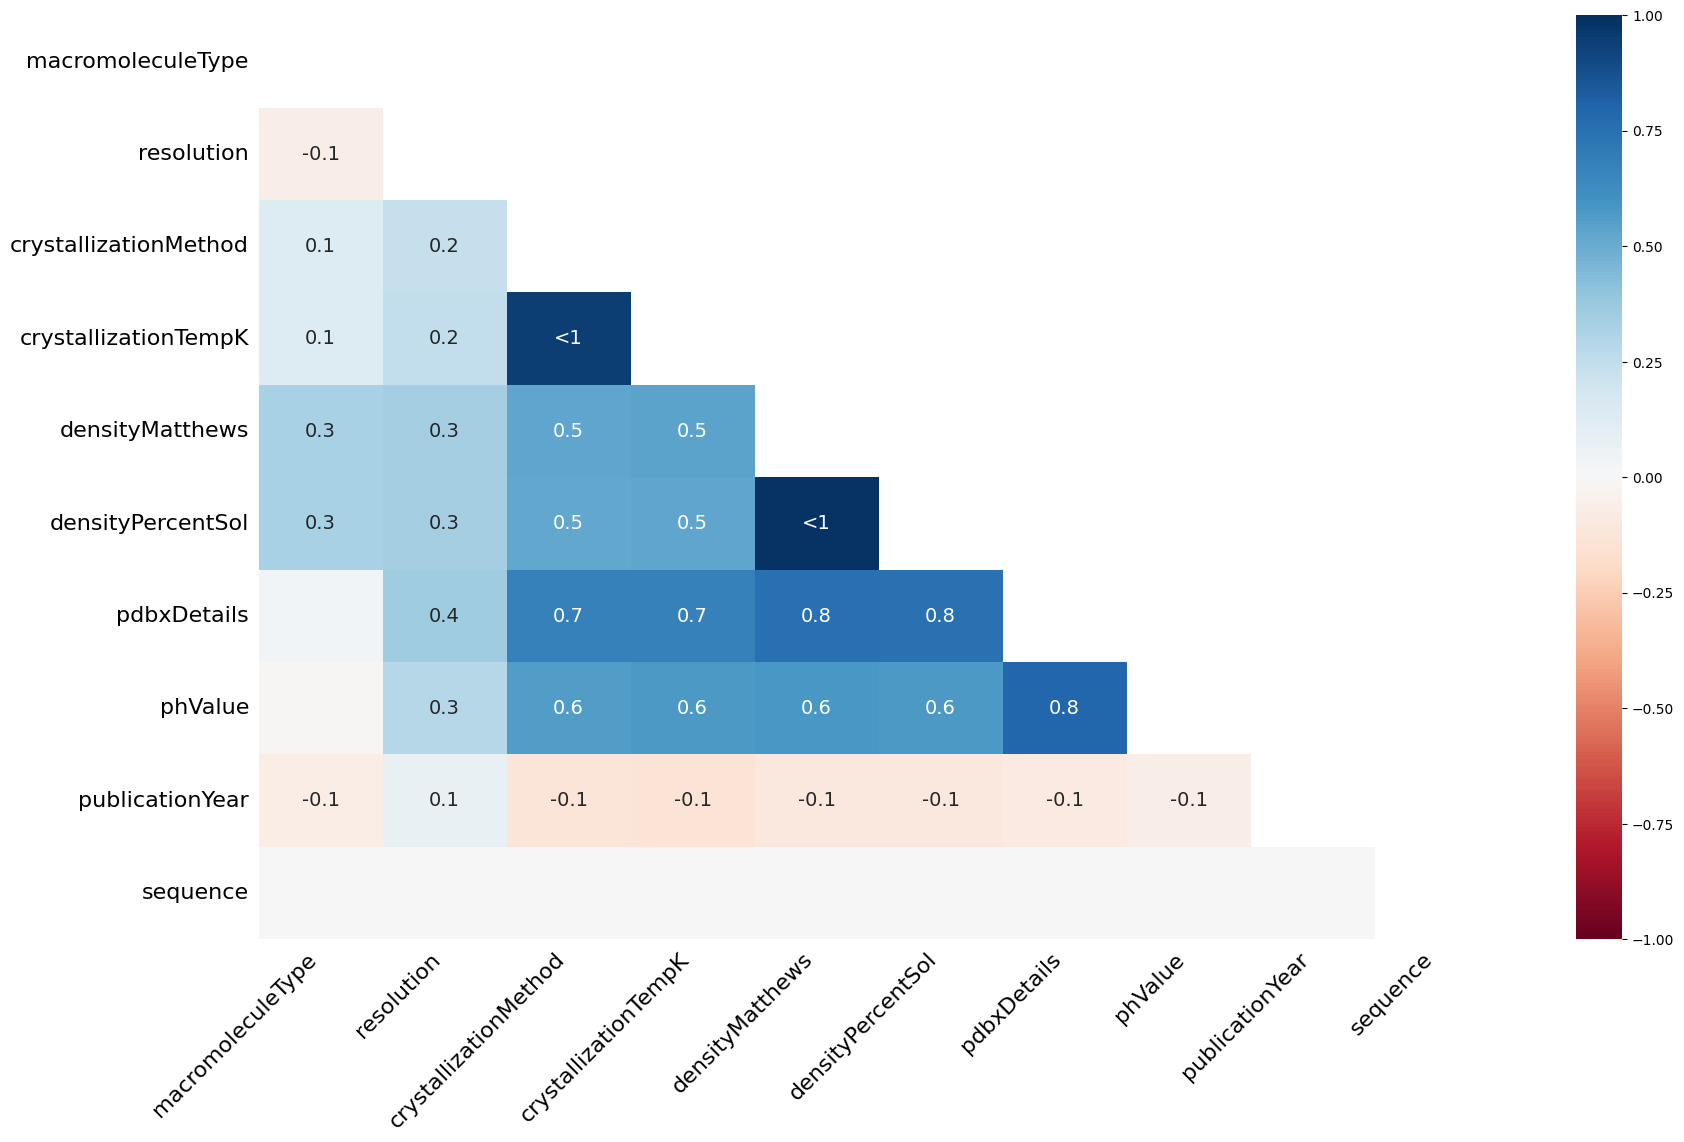

In [ ]:
msno.heatmap(df)

In [ ]:
df.isnull().sum()

,0
structureId,0
classification,0
experimentalTechnique,0
macromoleculeType,23306
residueCount,0
resolution,5634
structureMolecularWeight,0
crystallizationMethod,61252
crystallizationTempK,60595
densityMatthews,38189


In [ ]:

def map_to_broad_class(cls):
    if cls in ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'LYASE', 'ISOMERASE', 'LIGASE']:
        return 'ENZYME'
    elif cls in ['IMMUNE SYSTEM', 'TRANSCRIPTION', 'SIGNALING PROTEIN', 'PROTEIN BINDING',
                 'DNA BINDING PROTEIN', 'DNA']:
        return 'BINDING_REGULATORY'
    else:
        return 'STRUCTURAL_OTHER'


df['broad_class'] = df['classification'].apply(map_to_broad_class)
df=df.drop(columns=['classification'])



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               167384 non-null  object 
 1   experimentalTechnique     167384 non-null  object 
 2   macromoleculeType         144078 non-null  object 
 3   residueCount              167384 non-null  int64  
 4   resolution                161750 non-null  float64
 5   structureMolecularWeight  167384 non-null  float64
 6   crystallizationMethod     106132 non-null  object 
 7   crystallizationTempK      106789 non-null  float64
 8   densityMatthews           129195 non-null  float64
 9   densityPercentSol         129135 non-null  float64
 10  pdbxDetails               132478 non-null  object 
 11  phValue                   118130 non-null  float64
 12  publicationYear           149216 non-null  float64
 13  sequence                  167382 non-null  object

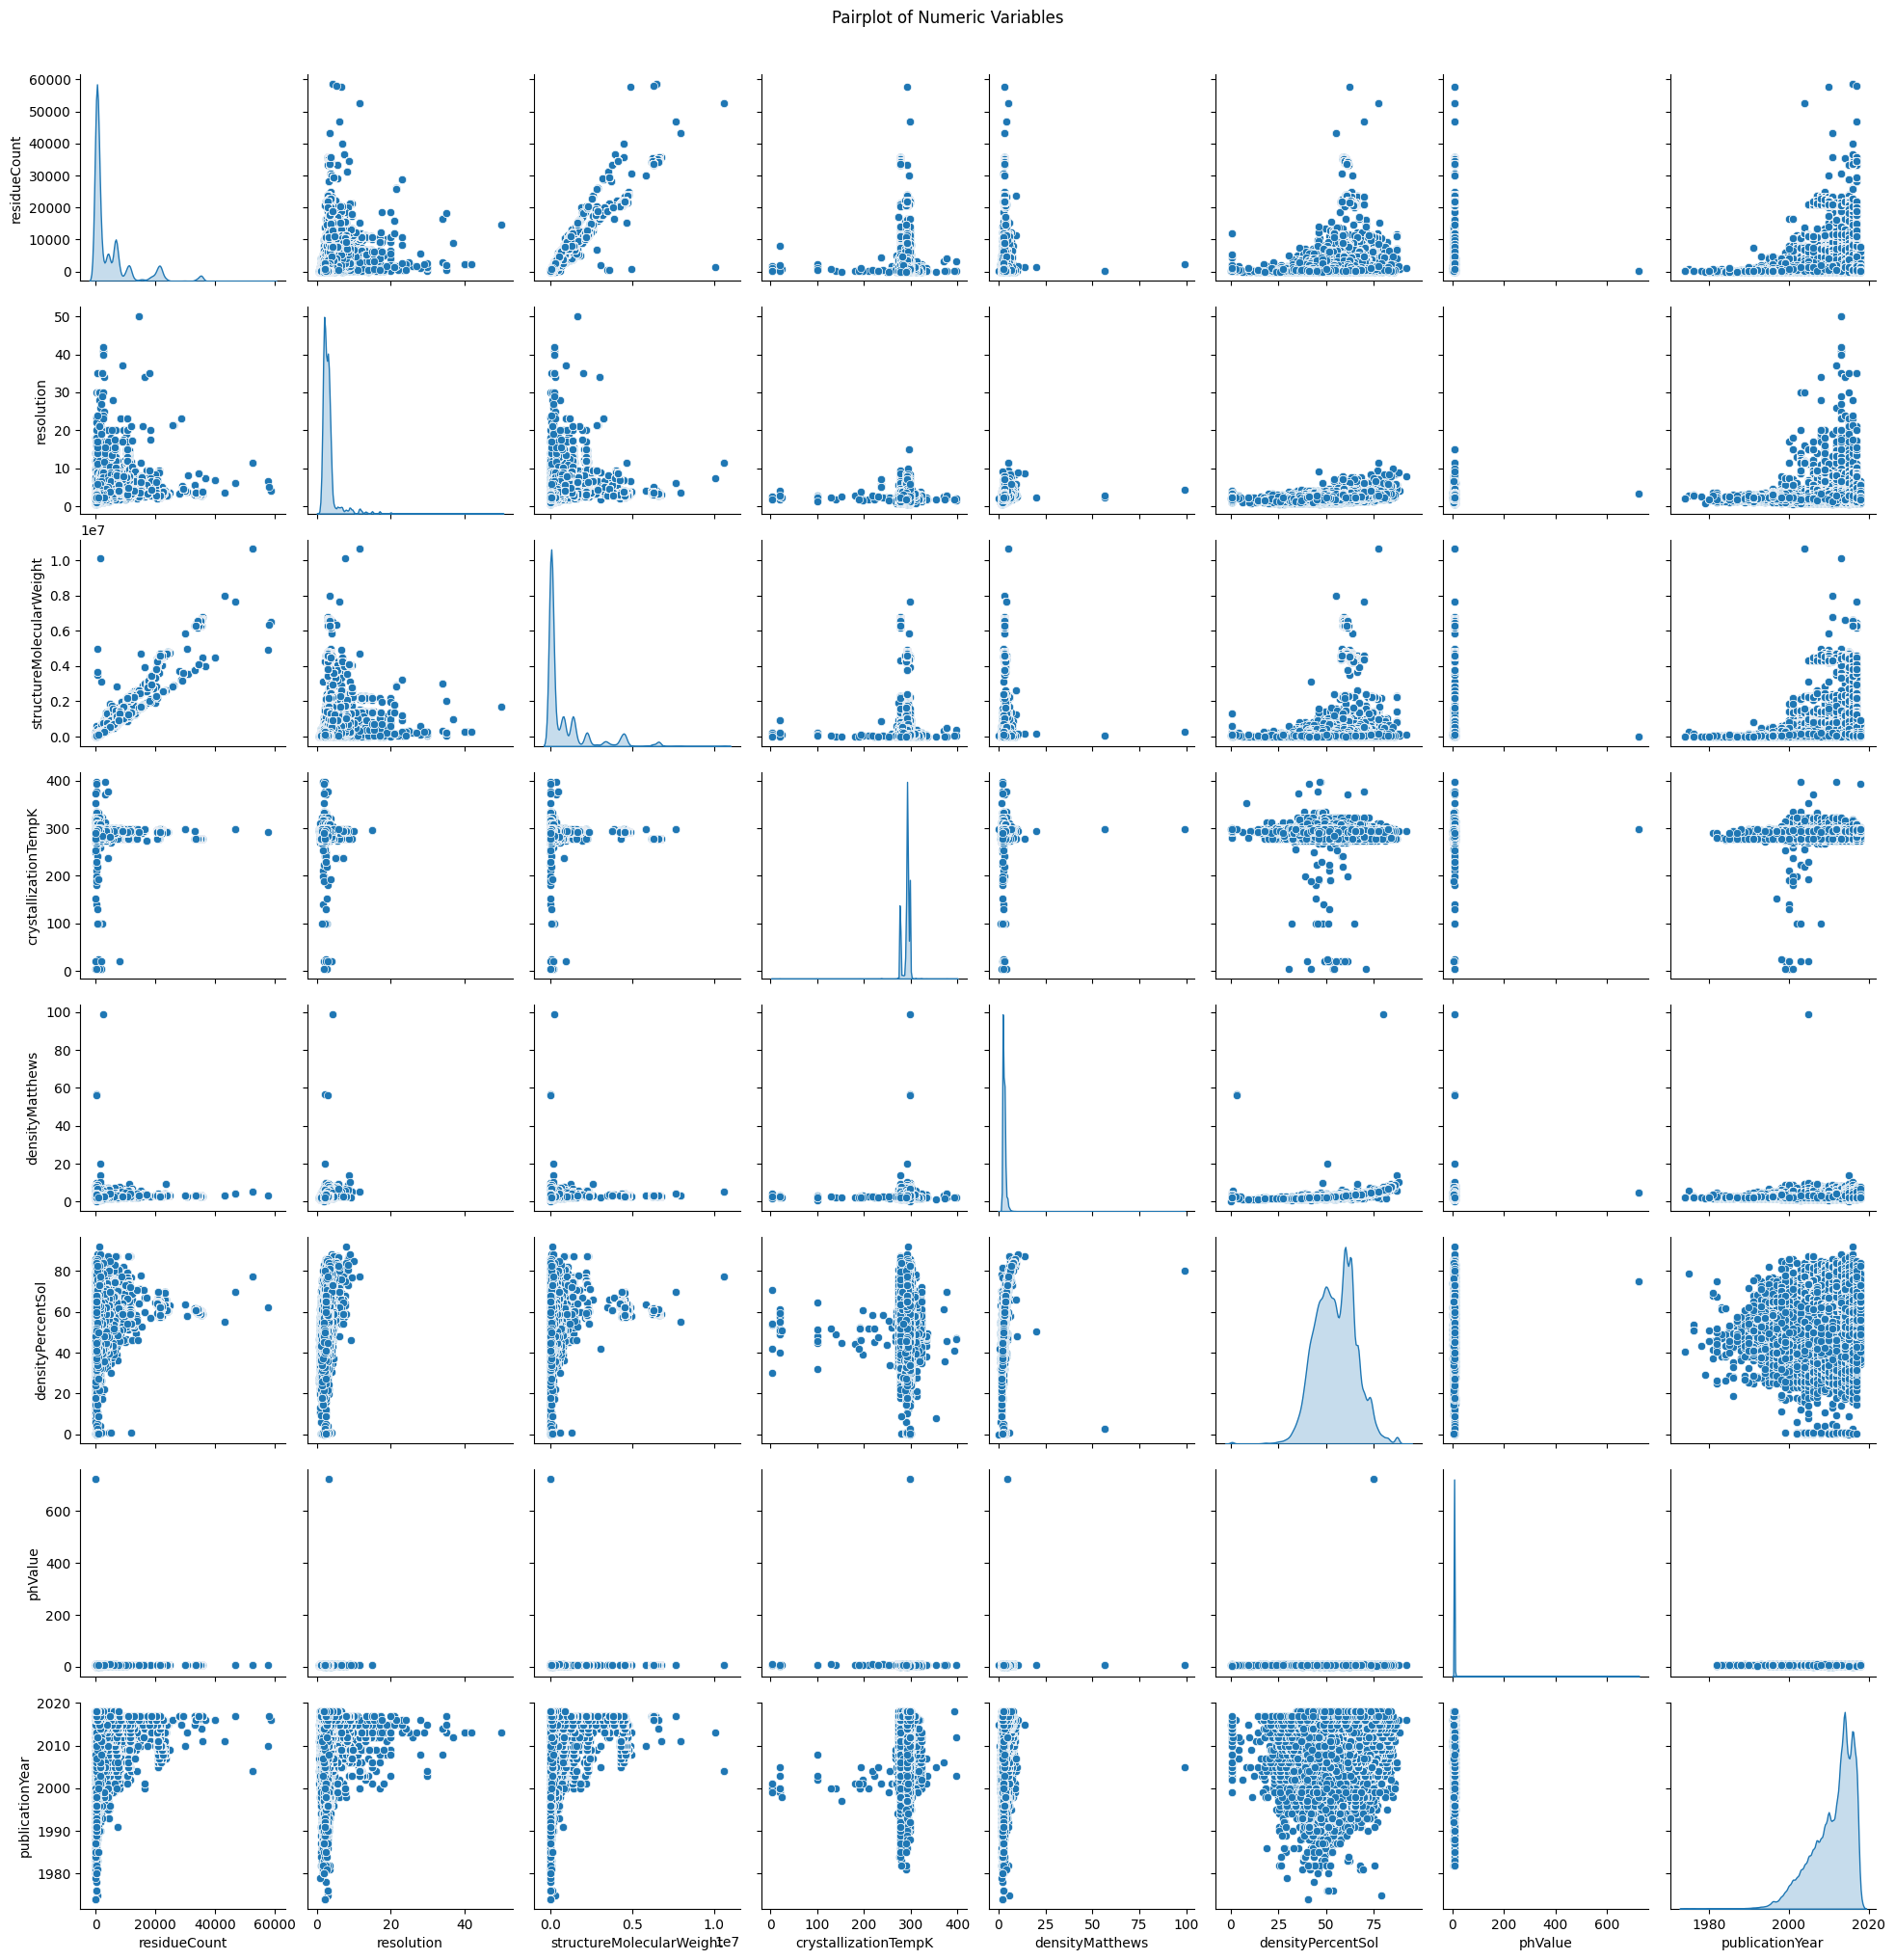

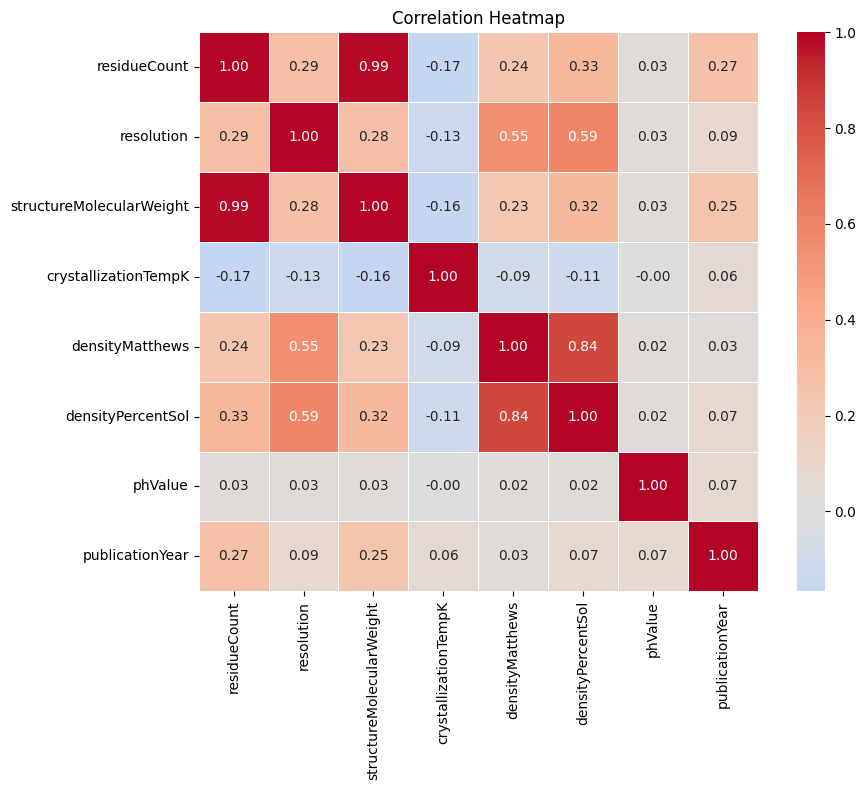

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns
df_numeric = df.select_dtypes(include='number')




sns.pairplot(df_numeric, diag_kind='kde')
plt.suptitle("Pairplot of Numeric Variables", y=1.02)
plt.show()

corr_matrix = df_numeric.corr()


# 2. Simple Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

    # 3. Clustered Heatmap (with dendrograms)


In [ ]:
columns_to_drop = [
    'crystallizationMethod',
    'crystallizationTempK',
    'phValue',
    'experimentalTechnique',
    'pdbxDetails',
    'publicationYear',
    'densityMatthews',
    'densityPercentSol'
    ,'resolution'
]
df_final = df.drop(columns=columns_to_drop)

In [ ]:

df_final.info()
print("shape:", df_final.shape)
print("\nRemaining columns:")
print(df_final.columns.tolist())
print("\nMissing values per column:")
print(df_final.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               167384 non-null  object 
 1   macromoleculeType         144078 non-null  object 
 2   residueCount              167384 non-null  int64  
 3   structureMolecularWeight  167384 non-null  float64
 4   sequence                  167382 non-null  object 
 5   broad_class               167384 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.9+ MB
shape: (167384, 6)

Remaining columns:
['structureId', 'macromoleculeType', 'residueCount', 'structureMolecularWeight', 'sequence', 'broad_class']

Missing values per column:
structureId                     0
macromoleculeType           23306
residueCount                    0
structureMolecularWeight        0
sequence                        2
broad_class                     0
dtype:

In [ ]:
df_final['macromoleculeType'] = df_final['macromoleculeType'].fillna('Unknown')

0

In [ ]:
print("Unique values in macromoleculeType:")
print(df_final['macromoleculeType'].unique())

print("\nValue counts (top 15):")
print(df_final['macromoleculeType'].value_counts().head(15))


Unique values in macromoleculeType:
['DNA' 'Protein' 'Protein#DNA' 'DNA/RNA Hybrid' 'Unknown' 'Protein#RNA'
 'RNA' 'RNA#DNA/RNA Hybrid' 'Protein#DNA#RNA' 'Protein#RNA#DNA/RNA Hybrid'
 'Protein#DNA#DNA/RNA Hybrid' 'DNA#RNA' 'Protein#DNA/RNA Hybrid'
 'DNA#DNA/RNA Hybrid']

Value counts (top 15):
macromoleculeType
Protein                       104823
Protein#RNA                    32201
Unknown                        23306
Protein#DNA                     3671
DNA                             2338
Protein#DNA#RNA                  710
Protein#RNA#DNA/RNA Hybrid       201
Protein#DNA#DNA/RNA Hybrid        55
RNA                               52
DNA#DNA/RNA Hybrid                12
Protein#DNA/RNA Hybrid             7
DNA#RNA                            4
DNA/RNA Hybrid                     2
RNA#DNA/RNA Hybrid                 2
Name: count, dtype: int64


In [ ]:

print("residueCount:")
invalid_rows = df_final[df_final['residueCount'] <= 0]
print(f"Number of invalid rows: {len(invalid_rows)}\n")
print(df_final['residueCount'].describe())
print("Zero/negative residueCount:", (df_final['residueCount'] <= 0).sum())


residueCount:
Number of invalid rows: 0

count    167384.000000
mean       4858.252414
std        7424.800331
min           2.000000
25%         386.000000
50%        1022.000000
75%        6614.000000
max       58591.000000
Name: residueCount, dtype: float64
Zero/negative residueCount: 0


In [ ]:
print("\nstructureMolecularWeight:")
print(df_final['structureMolecularWeight'].describe())
print("Zero/negative :", (df_final['structureMolecularWeight'] <= 0).sum())


structureMolecularWeight:
count    1.673840e+05
mean     8.682576e+05
std      1.430829e+06
min      5.724400e+02
25%      4.485632e+04
50%      1.161457e+05
75%      1.241064e+06
max      1.063775e+07
Name: structureMolecularWeight, dtype: float64
Zero/negative : 0


In [ ]:
class_counts = df_final['broad_class'].value_counts()
print("broad_class class distribution:")
print(class_counts)

broad_class class distribution:
broad_class
STRUCTURAL_OTHER      73710
ENZYME                67744
BINDING_REGULATORY    25930
Name: count, dtype: int64


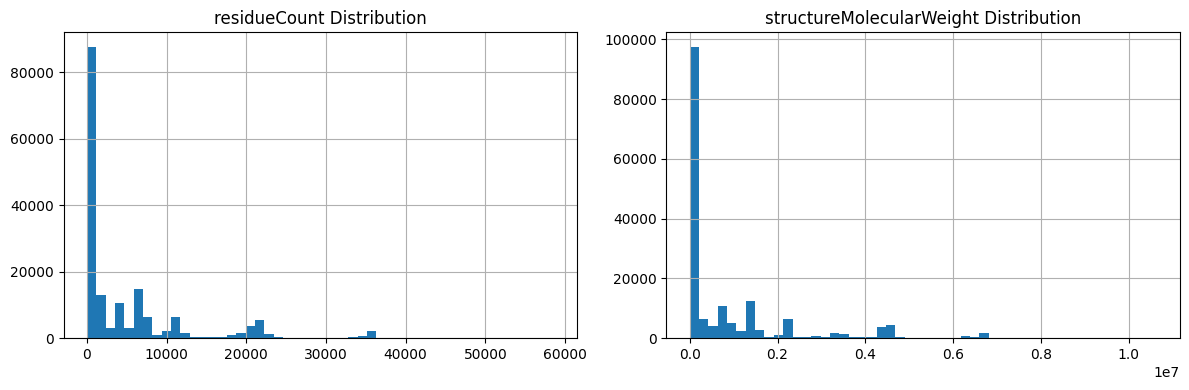

In [ ]:




import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_final['residueCount'].hist(bins=50, ax=axes[0])
axes[0].set_title('residueCount Distribution')


df_final['structureMolecularWeight'].hist(bins=50, ax=axes[1])
axes[1].set_title('structureMolecularWeight Distribution')


plt.tight_layout()
plt.show()





In [ ]:
0

0

In [ ]:
print("Unique values in macromoleculeType:")
print(df_final['macromoleculeType'].unique())

Unique values in macromoleculeType:
['DNA' 'Protein' 'Protein#DNA' 'DNA/RNA Hybrid' 'Unknown' 'Protein#RNA'
 'RNA' 'RNA#DNA/RNA Hybrid' 'Protein#DNA#RNA' 'Protein#RNA#DNA/RNA Hybrid'
 'Protein#DNA#DNA/RNA Hybrid' 'DNA#RNA' 'Protein#DNA/RNA Hybrid'
 'DNA#DNA/RNA Hybrid']


In [ ]:
from collections import Counter

def get_aac(sequence):
    if pd.isna(sequence):
        return [0]*20
    seq = str(sequence).upper()
    counts = Counter(seq)
    total = len(seq)
    # Standard 20 amino acids
    aas = list("ACDEFGHIKLMNPQRSTVWY")
    return [counts.get(aa, 0) / total for aa in aas]


aac_features = df_final['sequence'].apply(lambda x: pd.Series(get_aac(x)))
aac_features.columns = [f'aa_{aa}' for aa in "ACDEFGHIKLMNPQRSTVWY"]
df_final_clean=pd.concat([df_final, aac_features], axis=1)


In [ ]:
# One-hot encode macromoleculeType
df_encoded = pd.get_dummies(df_final_clean, columns=['macromoleculeType'], prefix='moltype')

print("Original columns:", df.columns.tolist())
print("\nNew columns after encoding:", df_final_clean.columns.tolist())
print(f"\nNumber of new columns added: {len(df_final_clean.columns) - len(df.columns)}")
print("Missing values after encoding:")
print(df_encoded.isnull().sum())

Original columns: ['structureId', 'experimentalTechnique', 'macromoleculeType', 'residueCount', 'resolution', 'structureMolecularWeight', 'crystallizationMethod', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'pdbxDetails', 'phValue', 'publicationYear', 'sequence', 'broad_class']

New columns after encoding: ['structureId', 'macromoleculeType', 'residueCount', 'structureMolecularWeight', 'sequence', 'broad_class', 'aa_A', 'aa_C', 'aa_D', 'aa_E', 'aa_F', 'aa_G', 'aa_H', 'aa_I', 'aa_K', 'aa_L', 'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W', 'aa_Y']

Number of new columns added: 11
Missing values after encoding:
structureId                           0
residueCount                          0
structureMolecularWeight              0
sequence                              2
broad_class                           0
aa_A                                  0
aa_C                                  0
aa_D                                  0
aa_E                

In [ ]:
print("Before scaling:")
print(df_encoded[['residueCount', 'structureMolecularWeight']].describe())

from sklearn.preprocessing import StandardScaler




Before scaling:
        residueCount  structureMolecularWeight
count  167384.000000              1.673840e+05
mean     4858.252414              8.682576e+05
std      7424.800331              1.430829e+06
min         2.000000              5.724400e+02
25%       386.000000              4.485632e+04
50%      1022.000000              1.161457e+05
75%      6614.000000              1.241064e+06
max     58591.000000              1.063775e+07


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
label_encoder = LabelEncoder()

# Fit and transform
df_encoded['broad_class'] = label_encoder.fit_transform(df_encoded['broad_class'])

print("Original class names (first 5):")
print(df_final_clean['broad_class'].head())

print("\nEncoded labels (first 5):")
print(df_encoded['broad_class'].head())

print(f"\nNumber of unique encoded labels: {df_encoded['broad_class'].nunique()}")


Original class names (first 5):
1     BINDING_REGULATORY
3     BINDING_REGULATORY
6     BINDING_REGULATORY
12    BINDING_REGULATORY
14    BINDING_REGULATORY
Name: broad_class, dtype: object

Encoded labels (first 5):
1     0
3     0
6     0
12    0
14    0
Name: broad_class, dtype: int64

Number of unique encoded labels: 3


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   structureId                         167384 non-null  object 
 1   residueCount                        167384 non-null  int64  
 2   structureMolecularWeight            167384 non-null  float64
 3   sequence                            167382 non-null  object 
 4   broad_class                         167384 non-null  int64  
 5   aa_A                                167384 non-null  float64
 6   aa_C                                167384 non-null  float64
 7   aa_D                                167384 non-null  float64
 8   aa_E                                167384 non-null  float64
 9   aa_F                                167384 non-null  float64
 10  aa_G                                167384 non-null  float64
 11  aa_H                           

After scaling:
       residueCount  structureMolecularWeight
count  1.673840e+05              1.673840e+05
mean  -1.392355e-17              1.006911e-16
std    1.000003e+00              1.000003e+00
min   -6.540603e-01             -6.064232e-01
25%   -6.023416e-01             -5.754733e-01
50%   -5.166824e-01             -5.256493e-01
75%    2.364714e-01              2.605539e-01
max    7.236950e+00              6.827874e+00


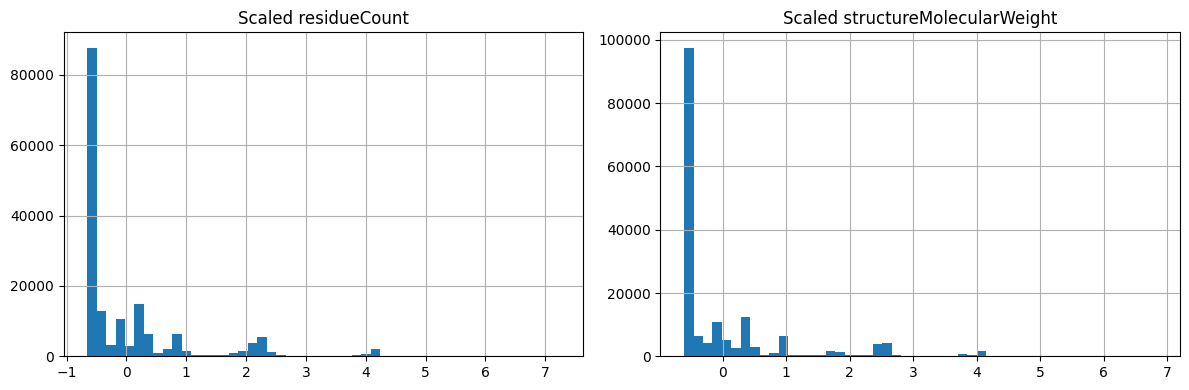

In [ ]:
num_cols = ['residueCount', 'structureMolecularWeight']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print("After scaling:")
print(df_encoded[num_cols].describe())
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_encoded['residueCount'].hist(bins=50, ax=axes[0])
axes[0].set_title('Scaled residueCount')


df_encoded['structureMolecularWeight'].hist(bins=50, ax=axes[1])
axes[1].set_title('Scaled structureMolecularWeight')


plt.tight_layout()
plt.show()

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   structureId                         167384 non-null  object 
 1   residueCount                        167384 non-null  float64
 2   structureMolecularWeight            167384 non-null  float64
 3   sequence                            167382 non-null  object 
 4   broad_class                         167384 non-null  int64  
 5   aa_A                                167384 non-null  float64
 6   aa_C                                167384 non-null  float64
 7   aa_D                                167384 non-null  float64
 8   aa_E                                167384 non-null  float64
 9   aa_F                                167384 non-null  float64
 10  aa_G                                167384 non-null  float64
 11  aa_H                           

In [ ]:
# df.info()
# # List of feature columns
# feature_cols = [col for col in df_encoded.columns
#                 if col not in ['structureId', 'broad_class','moltype_Protein']]



In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167384 entries, 1 to 253745
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   structureId                         167384 non-null  object 
 1   residueCount                        167384 non-null  float64
 2   structureMolecularWeight            167384 non-null  float64
 3   sequence                            167382 non-null  object 
 4   broad_class                         167384 non-null  int64  
 5   aa_A                                167384 non-null  float64
 6   aa_C                                167384 non-null  float64
 7   aa_D                                167384 non-null  float64
 8   aa_E                                167384 non-null  float64
 9   aa_F                                167384 non-null  float64
 10  aa_G                                167384 non-null  float64
 11  aa_H                           

In [ ]:
X= df_encoded.drop(['structureId', 'broad_class','moltype_Protein',"sequence"],axis=1)
y = df_encoded['broad_class']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.model_selection import train_test_split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train
rf_seq = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_seq.fit(X_train, y_train)

# Evaluate
y_pred = rf_seq.predict(X_test)
print("Accuracy with Sequence Features:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy with Sequence Features: 0.9218567972040506
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      5186
           1       0.89      0.94      0.92     13549
           2       0.96      0.93      0.95     14742

    accuracy                           0.92     33477
   macro avg       0.91      0.91      0.91     33477
weighted avg       0.92      0.92      0.92     33477



In [ ]:
!pip install xgboost lightgbm catboost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:04:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Model Comparison (Key Metrics):
                    Accuracy  Precision  Recall  F1-score
RandomForest          0.9219     0.9146  0.9057    0.9097
Bagging               0.9196     0.9099  0.9042    0.9067
ExtraTrees            0.9192     0.9129  0.9007    0.9061
XGBoost               0.9068     0.8977  0.8872    0.8914
DecisionTree          0.8945     0.8774  0.8734    0.8754
KNN                   0.8879     0.8753  0.8604    0.8668
LightGBM              0.8815     0.8540  0.8799    0.8635
AdaBoost              0.7913     0.7851  0.7253    0.7405
LogisticRegression    0.7551     0.7251  0.7414    0.7229


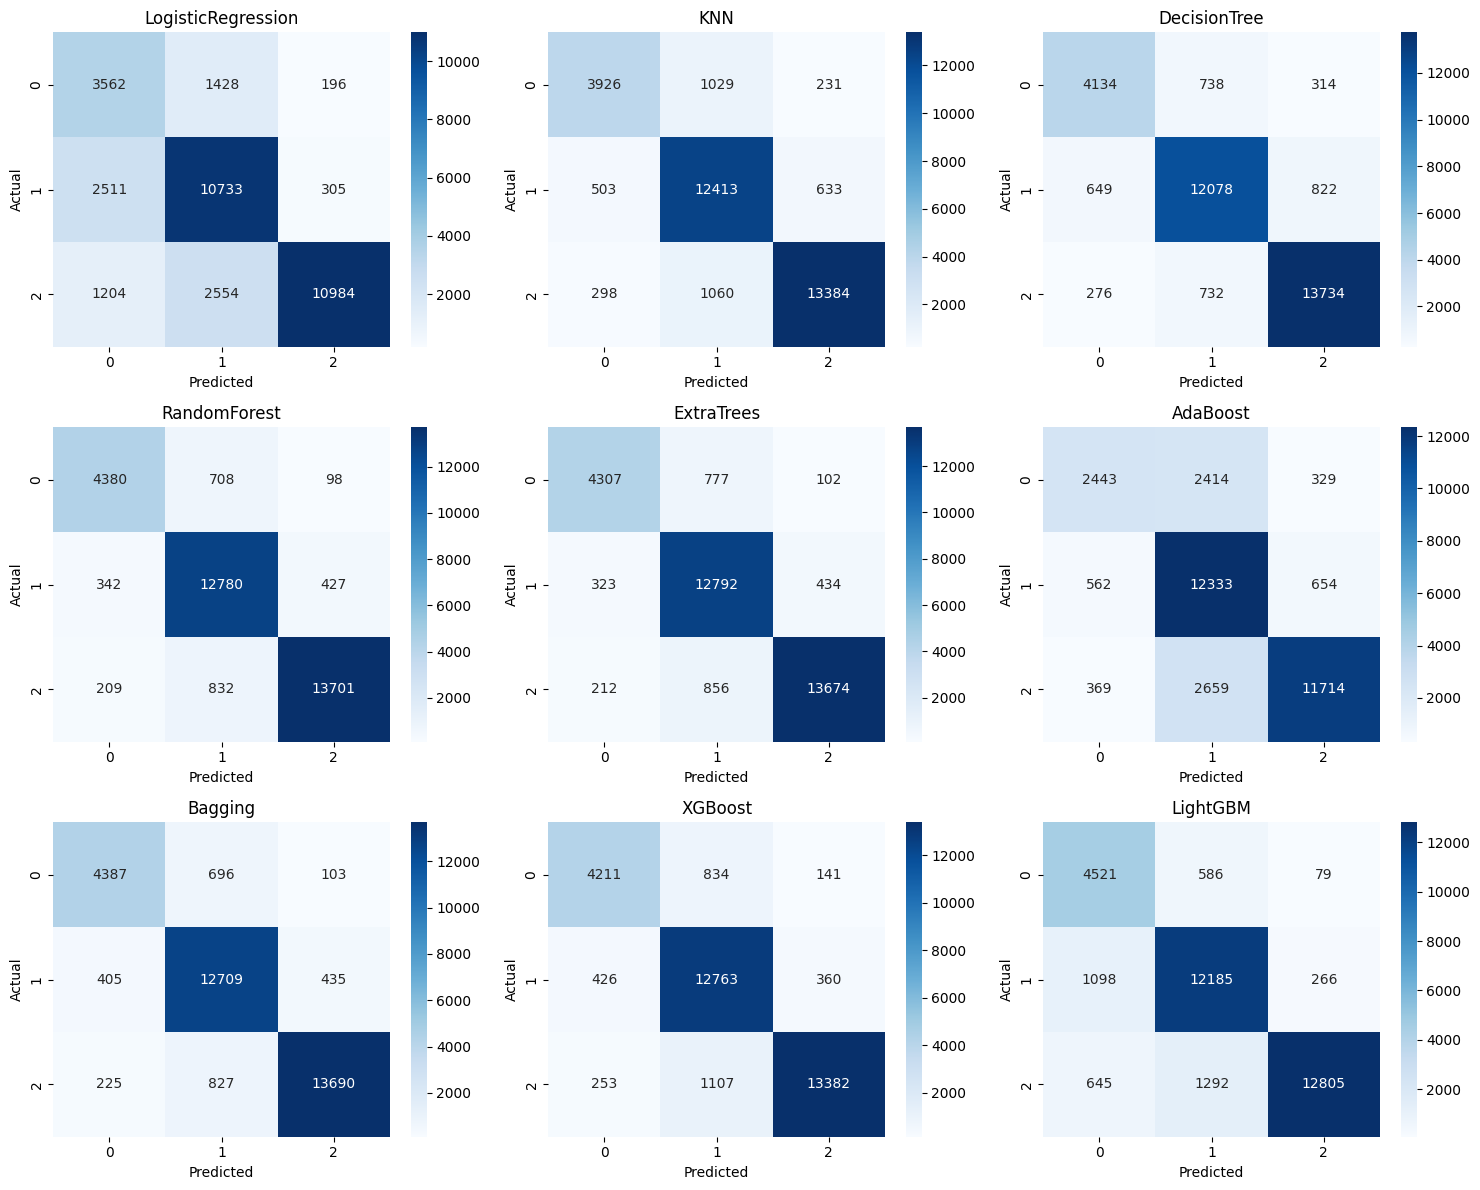

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, BaggingClassifier
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Define models ---
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Bagging": BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=50, random_state=42)
}

# Try to add XGBoost
try:
    from xgboost import XGBClassifier
    w = np.sum(y == 0) / np.sum(y == 1)
    models["XGBoost"] = XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss', scale_pos_weight=w)
except:
    pass

# Try to add LightGBM
try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42, verbosity=-1)
except:
    pass

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Evaluate models ---
results = {}
roc_curves = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)




    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Confusion Matrix": cm
    }

# --- Summary Table ---
summary_df = pd.DataFrame({
    name: {k: v for k, v in res.items() if k != "Confusion Matrix"}
    for name, res in results.items()
}).T.round(4)

summary_df = summary_df.sort_values("F1-score", ascending=False)
print("📊 Model Comparison (Key Metrics):")
print(summary_df.to_string())



# --- Plot Confusion Matrices (one per model) ---
n = len(results)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten() if n > 1 else [axes]

for idx, (name, res) in enumerate(results.items()):
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Hide empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()